# Bias Classification using Attention Features

This notebook implements the pipeline to classify biased sentences using features extracted from BERT attention mechanisms. 
It aims to identify which visualization techniques provides the best signals for detecting bias.

In [12]:
# Ensure dependencies are installed
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import spacy
except ImportError:
    print("spacy not found. Installing...")
    install("spacy")
    # Also download the model
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    print("Installed spacy and en_core_web_sm.")

In [13]:
import sys
import os
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Add root directory to path to import app modules
current_dir = os.getcwd()
# Assuming this notebook is in attention_app/bias/ or similar, adjust if needed
if 'attention_app' in current_dir:
    try:
        # Try to find the root by looking for 'attention_app' dir in parents
        while 'attention_app' in current_dir and os.path.basename(current_dir) != 'attention-atlas':
            current_dir = os.path.dirname(current_dir)
            if len(current_dir) < 5: break # simple safety
        root_dir = current_dir
    except:
        root_dir = os.path.dirname(os.path.dirname(os.getcwd()))
else:
    root_dir = current_dir
    
if root_dir not in sys.path:
    sys.path.append(root_dir)

print(f"Project root set to: {root_dir}")

from attention_app.models import ModelManager
from attention_app.bias.feature_extraction import extract_features_for_sentence

# Set plotting style
sns.set_theme(style="whitegrid")

Project root set to: c:\Users\anoca\Documents\GitHub\attention-atlas


## 1. Load Dataset into DataFrame
We load the curated 500-sentence dataset directly into a Pandas DataFrame for easier manipulation.

In [14]:
dataset_path = os.path.join(root_dir, 'dataset', 'bias_sentences.json')

if not os.path.exists(dataset_path):
    print(f"Warning: Dataset not found at {dataset_path}. Please check your path.")
else:
    # Load JSON and then convert 'entries' to DataFrame
    with open(dataset_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df_sentences = pd.DataFrame(data['entries'])
    print(f"Loaded {len(df_sentences)} sentences into DataFrame.")
    
    # Display the first few rows
    display(df_sentences.head())

Loaded 500 sentences into DataFrame.


,id,type,text,has_bias,bias_type,bias_description
0,1,single,The doctor said he would call the patient later.,True,gender,Assumes doctor is male
1,2,single,The nurse prepared the medication and checked ...,False,None,None
2,3,double,The nurse prepared the medication. She double-...,True,gender,Assumes nurse is female
3,4,double,The software developer wrote clean code. They ...,False,None,None
4,5,single,The CEO announced his new strategic initiative...,True,gender,Assumes CEO is male


## 2. Initialize Model
We use `bert-base-uncased` to extract attention weights.

In [15]:
model_name = "bert-base-uncased"
print(f"Loading NLP Model: {model_name}...")
manager = ModelManager()

Loading NLP Model: bert-base-uncased...


## 3. Extract Features
We extract granular features for every sentence. This includes:
- **Global Attention Metrics (GAM)**: Statistical distribution of attention per head.
- **Head Specialization**: Linguistic focus (syntax, semantics) per head.
- **ISA**: Inter-sentence dependency scores.
- **Tree**: Cumulative influence of leaf tokens.

In [16]:
feature_rows = []

print("Starting feature extraction...")

# Iterate over the DataFrame using tqdm for progress bar
for index, row in tqdm(df_sentences.iterrows(), total=df_sentences.shape[0]):
    text = row['text']
    # Convert boolean to int label
    label = 1 if row['has_bias'] else 0
    
    try:
        # Extract all thousands of features
        features = extract_features_for_sentence(text, model_name, manager)
        features['label'] = label
        features['original_id'] = row['id'] # Track original ID
        feature_rows.append(features)
    except Exception as e:
        print(f"Error processing sentence id {row.get('id', '?')}: {e}")

print("Extraction complete.")

Starting feature extraction...


  0%|          | 0/500 [00:00<?, ?it/s]

Extraction complete.


## 4. Preprocessing
Convert to DataFrame and handle any missing values.

In [ ]:
df_features = pd.DataFrame(feature_rows)
df_features = df_features.fillna(0)

print(f"Feature Matrix Shape: {df_features.shape}")
display(df_features.head())

# Show Feature List
print("\n--- Feature List ---")
all_features = list(df_features.columns)
print(f"Total Columns: {len(all_features)}")
print("Sample (first 50):")
print(all_features[:50])

# Uncomment to see ALL features (may be large)
for f in all_features:
    print(f)

Feature Matrix Shape: (500, 2237)


,GAM_L0_H0_confidence_max,GAM_L0_H0_confidence_avg,GAM_L0_H0_focus_entropy,GAM_L0_H0_sparsity,GAM_L0_H0_distribution_median,GAM_L0_H0_distribution_q25,GAM_L0_H0_distribution_q75,GAM_L0_H0_uniformity,GAM_L0_H1_confidence_max,GAM_L0_H1_confidence_avg,...,Tree_Leaf_42,Tree_Leaf_43,Tree_Leaf_44,Tree_Leaf_45,Tree_Leaf_46,Tree_Leaf_47,Tree_Leaf_48,Tree_Leaf_49,label,original_id
0,0.324385,0.195820,28.163292,0.000000,0.073436,0.052979,0.099159,0.048089,0.832440,0.383674,...,0.000117,0.000066,0.000062,0.000897,0.000401,0.000097,0.000042,0.000031,1,1
1,0.252648,0.160525,28.417147,0.013889,0.077355,0.059299,0.107065,0.040810,0.696013,0.315682,...,0.000074,0.000031,0.000029,0.000430,0.000346,0.000090,0.000032,0.000022,0,2
2,0.322451,0.130390,52.793472,0.036011,0.047351,0.033684,0.064085,0.033442,0.497881,0.236161,...,0.000168,0.000117,0.000098,0.000251,0.000229,0.000081,0.000027,0.000022,1,3
3,0.240730,0.137640,45.845009,0.006920,0.054209,0.037753,0.072023,0.032757,0.879596,0.293758,...,0.000072,0.000043,0.000036,0.000294,0.000265,0.000074,0.000041,0.000038,0,4
4,0.211450,0.136590,35.870983,0.000000,0.067715,0.049170,0.086476,0.029003,0.668674,0.339792,...,0.000144,0.000054,0.000040,0.000313,0.000169,0.000030,0.000027,0.000014,1,5



--- Feature List ---
Total Columns: 2237
Sample (first 50):
['GAM_L0_H0_confidence_max', 'GAM_L0_H0_confidence_avg', 'GAM_L0_H0_focus_entropy', 'GAM_L0_H0_sparsity', 'GAM_L0_H0_distribution_median', 'GAM_L0_H0_distribution_q25', 'GAM_L0_H0_distribution_q75', 'GAM_L0_H0_uniformity', 'GAM_L0_H1_confidence_max', 'GAM_L0_H1_confidence_avg', 'GAM_L0_H1_focus_entropy', 'GAM_L0_H1_sparsity', 'GAM_L0_H1_distribution_median', 'GAM_L0_H1_distribution_q25', 'GAM_L0_H1_distribution_q75', 'GAM_L0_H1_uniformity', 'GAM_L0_H2_confidence_max', 'GAM_L0_H2_confidence_avg', 'GAM_L0_H2_focus_entropy', 'GAM_L0_H2_sparsity', 'GAM_L0_H2_distribution_median', 'GAM_L0_H2_distribution_q25', 'GAM_L0_H2_distribution_q75', 'GAM_L0_H2_uniformity', 'GAM_L0_H3_confidence_max', 'GAM_L0_H3_confidence_avg', 'GAM_L0_H3_focus_entropy', 'GAM_L0_H3_sparsity', 'GAM_L0_H3_distribution_median', 'GAM_L0_H3_distribution_q25', 'GAM_L0_H3_distribution_q75', 'GAM_L0_H3_uniformity', 'GAM_L0_H4_confidence_max', 'GAM_L0_H4_confidence_

## 5. Train Classifier
We use a Random Forest Classifier to predict bias.

In [18]:
# Define Features (X) and Target (y)
# Exclude non-feature columns
drop_cols = ['label', 'original_id']
X = df_features.drop(columns=[c for c in drop_cols if c in df_features.columns])
y = df_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Model Performance on Test Set:
Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        56
           1       1.00      0.91      0.95        44

    accuracy                           0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



## 6. Analysis: Which Visualization is Best?
We aggregate feature importance scores by their source visualization.

In [19]:
importances = clf.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)

def get_viz_group(feature_name):
    if feature_name.startswith('GAM_'): return 'Global Attention Metrics'
    if feature_name.startswith('Spec_'): return 'Head Specialization'
    if feature_name.startswith('ISA_'): return 'Inter-Sentence Attention'
    if feature_name.startswith('Tree_'): return 'Dependency Tree'
    return 'Other'
    
fi_df['Visualization'] = fi_df['feature'].apply(get_viz_group)

# Compute aggregations
viz_importance = fi_df.groupby('Visualization')['importance'].sum().sort_values(ascending=False)
viz_avg_importance = fi_df.groupby('Visualization')['importance'].mean().sort_values(ascending=False)

print("Total Information by Visualization:")
display(viz_importance)

Total Information by Visualization:


Visualization
Head Specialization         0.582680
Global Attention Metrics    0.400959
Dependency Tree             0.016265
Inter-Sentence Attention    0.000097
Name: importance, dtype: float64

C:\Users\anoca\AppData\Local\Temp\ipykernel_35300\873712417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=viz_importance.values, y=viz_importance.index, palette='viridis')


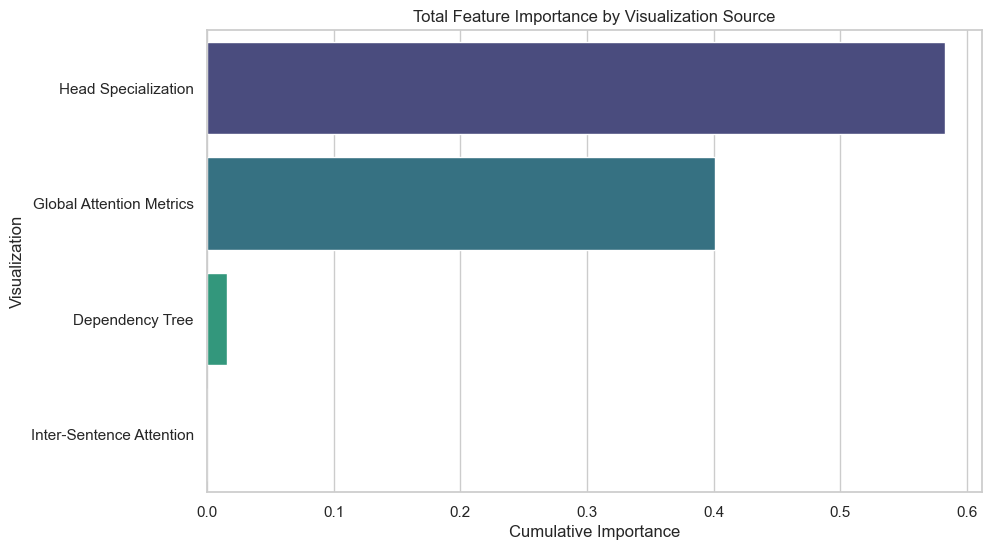

In [20]:
# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=viz_importance.values, y=viz_importance.index, palette='viridis')
plt.title('Total Feature Importance by Visualization Source')
plt.xlabel('Cumulative Importance')
plt.show()

## 7. Top Individual Features
These are the specific granular features (e.g., specific heads) that detect bias best.

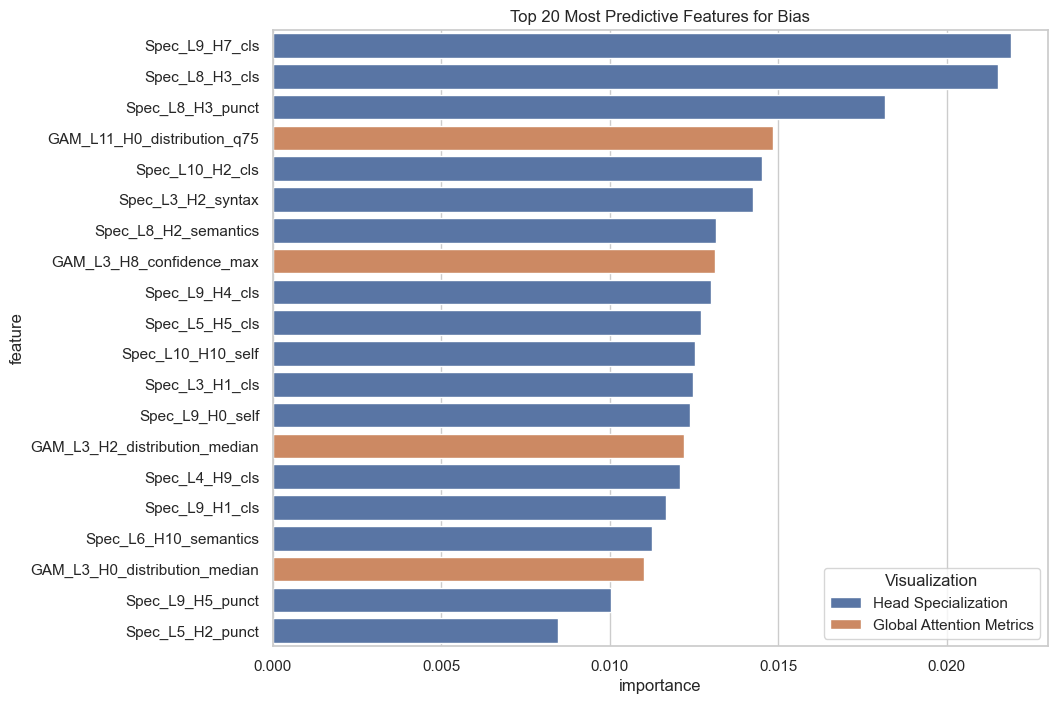

In [21]:
top_20 = fi_df.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', hue='Visualization', data=top_20, dodge=False)
plt.title('Top 20 Most Predictive Features for Bias')
plt.show()